In [ ]:
import random
import torch
from tqdm import tqdm
from transformers import LlamaForCausalLM, AutoTokenizer
import numpy as np
import pickle
from code.utils import disambiguate_prompt
import matplotlib.pyplot as plt
import seaborn as sns

/raid/speech/harshavardhan/miniconda3/envs/llama-icll/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random.seed(42)
torch.random.manual_seed(42)

symbols = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

model_name = "llama3"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = LlamaForCausalLM.from_pretrained(model_name)
model.to(dev)
model.eval()


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (n

In [6]:
def get_accuracy(model, seq_length, length_X, dataset):
        pfa_data = pickle.load(open(f"./data/{dataset}/val_pfa_data.pkl", "rb"))
        examples = open(f"./data/{dataset}/val.txt", "r").readlines()

        total_acc = [0.0]*seq_length

        examples = open(f'data/{dataset}/val.txt', 'r').readlines()
        examples = [x.strip() for x in examples]

        for n in range(0, len(examples), 10):

                model_inputs = tokenizer([example.strip() for example in examples[n: n+10]], return_tensors="pt")["input_ids"].to(dev)

                with torch.no_grad():
                        outputs = model.forward(model_inputs)

                        predictions = outputs.logits.argmax(-1).cpu().numpy()

                        labels = model_inputs.cpu().numpy()

                        for i in range(10):
                                indices = np.nonzero((labels[i] >= 64) & (labels[i] <= 89))
                                label = ''.join(tokenizer.convert_ids_to_tokens(labels[i, indices].squeeze()))[-seq_length*length_X:]
                                new_indices = tuple(idx - 1 for idx in indices)
                                prediction = ''.join(tokenizer.convert_ids_to_tokens(predictions[i, new_indices].squeeze()))[-seq_length*length_X:]

                                acc = np.zeros(seq_length)
                                for idx in range(length_X):
                                        acc += pfa_data[n+i][idx].evaluate_sequence(label[idx*seq_length: (idx+1)*seq_length], prediction[idx*seq_length: (idx+1)*seq_length])
                                acc = [x/(length_X) for x in acc]

                                total_acc = [x+y for x, y in zip(total_acc, acc)]

        print("Accuracy:", [x/len(examples) for x in total_acc])
        
        return sum(total_acc) / (len(examples)*seq_length), total_acc[0]/len(examples)

In [ ]:
acc = np.zeros((8, 8))
acc_1 = np.zeros((8, 8))

for length_X in tqdm(range(1, 9)):
        for seq_length in range(1, 9):
                dataset = f'monotonic-m{length_X}-c{seq_length}'
                acc[seq_length-1, length_X-1], acc_1[seq_length-1, length_X-1] = get_accuracy(model, seq_length, length_X, dataset)  

In [9]:
pickle.dump(acc, open("dump/standard_acc.pkl", "wb"))
pickle.dump(acc_1, open("dump/standard_acc_1.pkl", "wb"))

In [3]:
acc = pickle.load(open("dump/standard_acc.pkl", "rb"))
acc_1 = pickle.load(open("dump/standard_acc_1.pkl", "rb"))

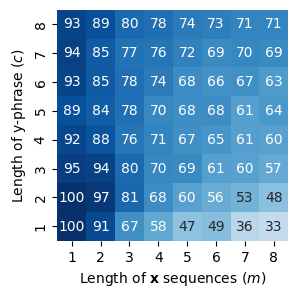

In [4]:
plt.figure(figsize=(3, 3))

sns.heatmap((acc[:,:]*100).round(), xticklabels=range(1,9), yticklabels=range(1,9), 
            cmap="Blues", square=True, annot=True, fmt=".0f", vmin=10, vmax=100, cbar_kws={"shrink": 0.8}, cbar=False)

plt.ylabel('Length of y-phrase ($c$)', fontsize=10)
plt.xlabel('Length of $\\mathbf{x}$ sequences ($m$)', fontsize=10)

plt.gca().invert_yaxis()

plt.savefig("figures/standard_acc.png", dpi=300, bbox_inches='tight')

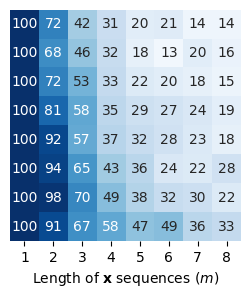

In [5]:
plt.figure(figsize=(3, 3))

sns.heatmap((acc_1[:,:]*100).round(), xticklabels=range(1,9), yticklabels=range(1,9), 
            cmap="Blues", square=True, annot=True, fmt=".0f", vmin=10, vmax=100, cbar_kws={"shrink": 0.8}, cbar=False)

plt.xlabel('Length of $\\mathbf{x}$ sequences ($m$)', fontsize=10)
plt.yticks([])

plt.gca().invert_yaxis()

plt.savefig("figures/standard_acc_1.png", dpi=300, bbox_inches='tight')

In [10]:
def get_accuracy(model, seq_length, length_X, dataset):
        pfa_data = pickle.load(open(f"./data/{dataset}/val_pfa_data.pkl", "rb"))
        examples = open(f"./data/{dataset}/val.txt", "r").readlines()

        total_acc = [0.0]*seq_length

        examples = open(f'data/{dataset}/val.txt', 'r').readlines()
        examples = [disambiguate_prompt(x.strip(), seq_length, length_X, 14) for x in examples]

        for n in range(0, len(examples), 5):

                model_inputs = tokenizer([example.strip() for example in examples[n: n+5]], return_tensors="pt")["input_ids"].to(dev)

                with torch.no_grad():
                        outputs = model.forward(model_inputs)

                        predictions = outputs.logits.argmax(-1).cpu().numpy()

                        labels = model_inputs.cpu().numpy()

                        for i in range(5):
                                indices = np.nonzero((labels[i] >= 64) & (labels[i] <= 89))
                                label = ''.join(tokenizer.convert_ids_to_tokens(labels[i, indices].squeeze()))[-seq_length*length_X:]
                                new_indices = tuple(idx - 1 for idx in indices)
                                prediction = ''.join(tokenizer.convert_ids_to_tokens(predictions[i, new_indices].squeeze()))[-seq_length*length_X:]

                                acc = np.zeros(seq_length)
                                for idx in range(length_X):
                                        acc += pfa_data[n+i][idx].evaluate_sequence(label[idx*seq_length: (idx+1)*seq_length], prediction[idx*seq_length: (idx+1)*seq_length])
                                        
                                        # for j in range(seq_length):
                                        #         if pfa_data[i][idx].check_sequence(label[idx*seq_length:idx*seq_length+j]+prediction[idx*seq_length+j]):
                                        #                 acc[j]+=1
                                
                                acc = [x/(length_X) for x in acc]

                                total_acc = [x+y for x, y in zip(total_acc, acc)]

        print("Accuracy:", [x/len(examples) for x in total_acc])
        
        return sum(total_acc) / (len(examples)*seq_length)

In [11]:
acc = np.zeros((8, 8))

plt.figure(figsize=(5, 5))

for length_X in tqdm(range(8, 9)):
        for seq_length in range(1, 2):
                dataset = f'monotonic-m{length_X}-c{seq_length}'
                acc[seq_length-1, length_X-1] = get_accuracy(model, seq_length, length_X, dataset)  

100%|██████████| 1/1 [00:26<00:00, 26.83s/it]

Accuracy: [0.959375]


<Figure size 500x500 with 0 Axes>

In [12]:
pickle.dump(acc, open("dump/disambiguated_acc_reduced.pkl", "wb"))

In [6]:
acc = pickle.load(open("dump/disambiguated_acc.pkl", "rb"))

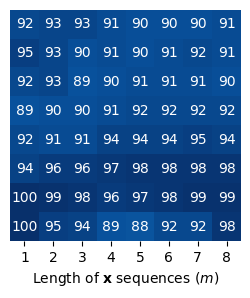

In [7]:
plt.figure(figsize=(3, 3))

sns.heatmap((acc[:,:]*100).round(), xticklabels=range(1,9), yticklabels=range(1,9), 
            cmap="Blues", square=True, annot=True, fmt=".0f", vmin=14, vmax=100, cbar_kws={"shrink": 0.8}, cbar=False)

plt.xlabel('Length of $\\mathbf{x}$ sequences ($m$)', fontsize=10)
plt.yticks([])

plt.gca().invert_yaxis()

plt.savefig("figures/disambiguated_acc.png", dpi=300, bbox_inches='tight')